In [44]:
# 介绍 : 新算法,加高斯noise

In [45]:
# Python imports
import numpy as np # Matrix and vector computation package
import matplotlib.pyplot as plt  # Plotting library
# Allow matplotlib to plot inside this notebook
%matplotlib inline
# Set the seed of the numpy random number generator so that the tutorial is reproducable
np.random.seed(seed=1)
from sklearn import datasets, cross_validation, metrics # data and evaluation utils 
from matplotlib.colors import colorConverter, ListedColormap # some plotting functions
import itertools
import collections
from scipy import stats
from scipy.stats import weibull_min
import matplotlib.pyplot as plt
from __future__ import division
import random
import math

In [46]:
#给逻辑层的输出的头部插入1
def array_add_data(activ):
    """
    参数activ : 每层的输出(激活)  第一层 : (32L, 20L)
    作用 : 在数组头部插入数值1
    """
    r = []
    ret1 = 0
    for i in range(activ.shape[0]):
        ret1 = np.array(np.append([1],activ[i])) #list
        r.append(ret1)
    r = np.array(r) # 类型转换:list -> array
    return r

#给所有样本头部插入1
def array_add_data2(activ):
    """
        参数activ : 样本
        作用 : 在数组头部插入数值1
    """
    r = []
    ret1 = np.append([1],activ)
    r.append(ret1)
    ret2 = np.array(r)
    return ret2

In [47]:
# Define the non-linear functions used
def logistic(z): 
    return 1 / (1 + np.exp(-z))

# def logistic_deriv(y):  # Derivative of logistic function
#     return np.multiply(y, (1 - y))
    
def softmax(z): 
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

#激活函数:leaky_relu
def leaky_relu(d,s):
    """
        f(x) = x , x>=0
        f(x) = sx , x<0
    """
    for i in range(len(d[0])):
        if d[0][i] >= 0:
            d[0][i] = d[0][i]
        else:
            d[0][i] = s*d[0][i]
    return d

#激活函数:阈值函数
def threshold_function(d):
    """
        f(x) = 1 , x>=0
        f(x) = 0 , x<0
    """
    for i in range(len(d[0])):
        if d[0][i] >= 0:
            d[0][i] = 1
        else:
            d[0][i] = 0
    return d

In [49]:
# Define the layers used in this model
class Layer(object):
    
#     def get_params_iter(self):
#         return []
    
#     def get_params_grad(self, X, output_grad):
#         return []
      
#     def get_params_update(self, X, loss):
#         return []
    
#     def add_noise(self):
#         pass
    
#     def remove_noise(self):
#         pass
    
    def get_output(self, X):
        pass
    
#     def get_input_grad(self, Y, output_grad=None, T=None):
#         pass

In [50]:
class discreteLayer(Layer):
    """The linear layer performs a linear transformation to its input."""
    
    def __init__(self, n_in, n_out):
        """ 
            对隐藏层参数进行初始化
            n_in是输入变量的数量
            n_out是输出变量的数量
        """
        self.W = np.random.randn(n_in, n_out) * 0.1
        self.W[0:1,:] = 0
    
    def get_output(self, X):
        # 线性变换
        xw = X.dot(self.W)
        re = xw + self.noise 
        return re

In [51]:
# 两个gard相加求平均
def get_grad_average(g1,g2,times):
    for i in range(len(g1)):
        g1[i] += g2[i]
        g1[i] = g1[i] / times
    return g1

[array([[0.5, 0.5, 0.5, 0.5, 0.5],
       [1. , 1. , 1. , 1. , 1. ]]), array([[0.5, 0.5, 0.5, 0.5, 0.5],
       [1. , 1. , 1. , 1. , 1. ],
       [1.5, 1.5, 1.5, 1.5, 1.5],
       [2. , 2. , 2. , 2. , 2. ],
       [2.5, 2.5, 2.5, 2.5, 2.5]])]


In [52]:
from __future__ import division
#对数组中的每个值除以一个数
def average_array(l,num):
    for i in range(len(l)):
        l[i] = l[i] / num
#test
# dd = np.array([1,2,3,4,5,6])
# print(dd[0]/2)
# print(dd[0]/2)
# print(dd[1]/3)
# print(dd[2]/2)

In [53]:
class LogisticLayer(Layer):
    """The logistic layer applies the logistic function to its inputs."""
    
#     def __init__(self):
#         self.noise = 0
#         self.b = 0
    
    def get_output(self, X):
        # 在头部插入数值1
        #logi = logistic(X)
        logi = threshold_function(X) #阈值函数
        Y = array_add_data(logi)
        
#         print("=============== 逻辑层 ================")
#         print(logi)
#         print("--------------------------------------------------------------")
#         print(Y)
        
        return Y
    
#     def get_input_grad(self, Y, output_grad):
#         return np.multiply(logistic_deriv(Y), output_grad)

In [54]:
class SoftmaxOutputLayer(Layer):
    """ 
        输出层
    """  
#     def __init__(self):
#         self.noise = 0
#         self.b = 0
    
    def get_output(self, X):
        r = softmax(X)
#         print("-------------- softmax --------------")
#         print(X)
#         print("----->")
#         print(r)
        return r
    
    def get_cost(self, A, T):
        
#         print("--------- cost ----------")
#         print(A)
#         print(T)
#         print("T.shape : " + str(T.shape))
#         print("A.shape : " + str(A.shape))
#         print("A.shape[0] : " + str(A.shape[0]))
        
        re = - np.multiply(T, np.log(A)).sum() / A.shape[0]      #A.shape[0]                         大更改  单样本时应该除以1
        return re

In [55]:
def forward_step(input_samples,layers,noise1):
    activations = [input_samples] 
    X = input_samples
    for index in range(len(layers)): 
        layer = layers[index]
        layer.noise = noise1[index]
        Y = layer.get_output(X)
        activations.append(Y)  
        X = activations[-1]  
    return activations  

In [56]:
# 验证时的forward : 不加高斯noise
def forward_step2(input_samples,layers):
    activations = [input_samples] 
    X = input_samples
    for index in range(len(layers)): 
        layer = layers[index]
        layer.noise = 0
        Y = layer.get_output(X)
        activations.append(Y)  
        X = activations[-1]  
    return activations  

In [57]:
#处理样本

# 在所有样本的头部添加数值1
digits = datasets.load_digits()
d = digits.data # array
# print(data.shape) # (1797L, 64L)
target_list = [] # list
target_data = []
# single_array = np.array([1])
for i in range(len(d)):
    # 取出数据
    a = d[i]
    # 头部添加1 
    a_temp = array_add_data2(a)[0]
    # 添加到总的array中
    target_list.append(a_temp)
target_data = np.array(target_list) 

T = np.zeros((digits.target.shape[0],10))
T[np.arange(len(T)), digits.target] += 1

#有问题 : 这里的划分应该是随机的,和digits.data不对应
X_train, X_test, T_train, T_test = cross_validation.train_test_split(
    target_data, T, test_size=0.4)
X_validation, X_test, T_validation, T_test = cross_validation.train_test_split(
    X_test, T_test, test_size=0.5)

In [58]:
# 需要用batch时,取batch整倍的样本:43 * 25 = 1075
X_train2 = X_train[0:1075,]
T_train2 = T_train[0:1075,]

1075
(1075L, 65L)
(1075L, 10L)
43.12
3
43 * 25 = 1075
1078


In [59]:
# 创建minibatches
batch_size = 25     # djust
nb_of_batches = 43  # 32批
# # Create batches (X,Y) from the training set
# XT_batches = zip(
#     np.array_split(X_train, nb_of_batches, axis=0),  
#     np.array_split(T_train, nb_of_batches, axis=0)) 

In [60]:
# 获得grad
def get_grad(ac,noise,sigm,loss):
    grad = []
    gra = 0
    for i in range(len(noise)):
        if i%2 == 0 :
            a = ac[i]
            noi = noise[i]
            do  = a.T.dot(noi)
            gra = ( do * loss ) / (sigm**2)  # (20L,65L)  (10L,20L)
            grad.append(gra)
    return grad

In [61]:
def update_params(layers,grad,learning_rate):
    """
        更新选定节点的权重
    """
    layers[0].W -= learning_rate * grad[0]
    layers[2].W -= learning_rate * grad[1]

In [62]:
# 定义模型
hidden_neurons_1 = 20  # 第一个隐藏层的神经元数目
layers = [] #
# 添加第一个隐层
layers.append(discreteLayer(X_train.shape[1], hidden_neurons_1))  
layers.append(LogisticLayer())
# 添加输出层
layers.append(discreteLayer(21, T_train.shape[1])) 
layers.append(SoftmaxOutputLayer())

# print(layers[0].W.shape)
# print(layers[2].W.shape)

In [63]:
w1 = np.zeros((65,20), dtype=float, order='C')
w2 = np.zeros((21,10), dtype=float, order='C')
zero_grad = []
zero_grad.append(w1)
zero_grad.append(w2)

In [66]:
#迭代训练 : 对所有样本进行训练

# 开始训练
sigm = 0.5  #35
learning_rate = 0.1
minibatch_cost = []
train_cost = []
validation_cost = []
# 执行10个epoch
nb_of_epoch = 30
# 单个样本训练次数
nb_of_single_sample = 10000

for i in range(nb_of_epoch):
    grad = zero_grad
    loss = 0
    # 总样本数1775
    for iteration in range(X_train2.shape[0]):  # batch_size = 25,每25个样本更新一次参数     nb_of_batches = 43

        # 提出一个样本
        x = X_train2[iteration]
        t = T_train2[iteration]
        x = np.expand_dims(x, axis=0) #(1L,65L)
        t = np.expand_dims(t, axis=0) #(1L,10L)

        # 单样本求一万次grad的平均
        for j in range(nb_of_single_sample):
            # 准备好各layer的高斯noise
            noise1 = []
            noise1.append(np.random.randn(1,20)*sigm)
            noise1.append([])
            noise1.append(np.random.randn(1,10)*sigm)
            noise1.append([])

            activations = forward_step(x,layers,noise1)
            # 累加每次的loss
            cur_loss = layers[-1].get_cost(activations[-1],t) # activations1[-1]二维数组: [[.....]]
            loss += cur_loss
            # 累加每次的grad
            cur_grad = get_grad(activations,noise1,sigm,cur_loss)
            grad = get_grad_average(grad,cur_grad,1)      # grad1:(65L,20L)  grad2:(21L,10L)

        # 计算完一个batch时更新权重w
        if (iteration+1) % 25 == 0:
            # 对累加的grad求平均
            grad[0] = grad[0] / (nb_of_single_sample*25)
            grad[1] = grad[1] / (nb_of_single_sample*25)
            # update weight
            update_params(layers,grad,learning_rate)
            # append train_set loss
            loss = loss / (nb_of_single_sample*25)
            print("loss : " + str(loss))
            minibatch_cost.append(loss)
            #grad和loss初始化为0
            grad = zero_grad
            loss = 0
            
            # append test_set loss
            train_activations = forward_step2(X_train2,layers)
            train_loss = layers[-1].get_cost(train_activations[-1],T_train2)
            train_cost.append(train_loss)
            # append validation_set loss
            val_activations = forward_step2(X_validation,layers)
            validation_loss = layers[-1].get_cost(val_activations[-1],T_validation)
            validation_cost.append(validation_loss)
            
        # 显示循环次数
        if (iteration + 1) % 200 == 0:
            print(iteration + 1)
    print("-------------- 第" + str( i + 1) + str("个epoch --------------"))

loss : 2.4035184374727545
loss : 2.4573860735498956
loss : 2.4339231416429596
loss : 2.444400554277404
loss : 2.3578123960687676
loss : 2.444684394884936
loss : 2.363129864937279
loss : 2.389496313616813
200
loss : 2.455084804644167
loss : 2.389722939075655
loss : 2.3797035210217516
loss : 2.426222389126725
loss : 2.389454579933961
loss : 2.432043415135998
loss : 2.4058999809009465
loss : 2.479670944820583
400
loss : 2.377034531066017
loss : 2.378117294758912
loss : 2.405437715525758
loss : 2.4010851436696328
loss : 2.3481385984062695
loss : 2.3257708198877207
loss : 2.40335317123227
loss : 2.339505832075668
600
loss : 2.3765237623739206
loss : 2.386729518198344
loss : 2.422711758265439
loss : 2.3949121227128516
loss : 2.368735523053208
loss : 2.3916798826686994
loss : 2.3403292380054848
loss : 2.3268182355753266
800
loss : 2.201536478302456
loss : 2.2621257606114042
loss : 2.2851680086554644
loss : 2.3656036869893837
loss : 2.2887949988026217
loss : 2.2857482627522203
loss : 2.3699969

loss : 1.1514740859909622
loss : 1.0358281794531532
loss : 1.0612191587954587
loss : 1.023990734367214
loss : 0.9546776799452287
loss : 0.9119388594183285
200
loss : 0.8532061022105362
loss : 0.9668844358353031
loss : 0.9899924333195473
loss : 0.9613792076296707
loss : 0.926109885983877
loss : 0.91754332321347
loss : 1.1511421733544802
loss : 0.981938075072755
400
loss : 0.90366558544566
loss : 0.8817616647194205
loss : 0.7589422561847498
loss : 0.8471294660541887
loss : 0.8226283195939567
loss : 0.8618167341718692
loss : 0.8435680267537334
loss : 0.8880192848424138
600
loss : 0.8720091799455063
loss : 1.0538488593398976
loss : 0.8454646505928793
loss : 0.924792160417693
loss : 0.7508420559032857
loss : 1.0078221601648125
loss : 0.9971481098341395
loss : 0.7996528154894512
800
loss : 0.6255406301551328
loss : 0.7060144617226808
loss : 0.9120917060097636
loss : 0.7618352685828146
loss : 0.7751169876464291
loss : 0.954940379849511
loss : 0.7192422461432234
loss : 0.9005873866748432
1000


loss : 0.4913709569427523
loss : 0.4803459378747402
loss : 0.5544031972524553
loss : 0.3711529812622017
loss : 0.46963749661401105
loss : 0.40439410411538285
loss : 0.36743564775268284
loss : 0.3148493423493641
200
loss : 0.3928954563419297
loss : 0.4776909982449786
loss : 0.3329001272393385
loss : 0.34008537148515694
loss : 0.3356369230751997
loss : 0.29802259135553844
loss : 0.6015493973334585
loss : 0.31464748826874583
400
loss : 0.32586995144242004
loss : 0.3482380781735889
loss : 0.24328887815681927
loss : 0.3255536751321141
loss : 0.39733255867528955
loss : 0.34053268193656805
loss : 0.34177324225033545
loss : 0.4129382562495794
600
loss : 0.4602194863838072
loss : 0.5277791888609801
loss : 0.41650286467028985
loss : 0.47597721947274124
loss : 0.3463727478231784
loss : 0.4274861364870146
loss : 0.462179880694918
loss : 0.4261317378093022
800
loss : 0.2546281087561472
loss : 0.28730957652876055
loss : 0.49644644283227196
loss : 0.33043361241987096
loss : 0.3269361246598162
loss : 

loss : 0.2744348760355211
loss : 0.2082813919848581
1000
loss : 0.35000604694636317
loss : 0.18974531918146445
loss : 0.3606417499510654
-------------- 第21个epoch --------------
loss : 0.2623780056679577
loss : 0.32599534600658375
loss : 0.35352500585578894
loss : 0.3670081178257051
loss : 0.2235624688201849
loss : 0.2374129412289787
loss : 0.17899104718690387
loss : 0.20776136599633754
200
loss : 0.32591149218090065
loss : 0.42903161840256093
loss : 0.2976235482819021
loss : 0.16330534918820133
loss : 0.3069434489763319
loss : 0.36624228850138474
loss : 0.3683417595482107
loss : 0.19826749598165772
400
loss : 0.1335142282817573
loss : 0.20336882416966592
loss : 0.12319068205228927
loss : 0.20265621687932506
loss : 0.23396907590558078
loss : 0.16567727490848855
loss : 0.205431284800563
loss : 0.188710136784626
600
loss : 0.2673686098064027
loss : 0.3330317585288116
loss : 0.28557176898050135
loss : 0.1781069892360643
loss : 0.18270418739728098
loss : 0.29686840130807995
loss : 0.3238790

loss : 0.6412020340540145
loss : 0.41064869259319287
800
loss : 0.3030069487915574
loss : 0.20010044980570266
loss : 0.30112048124600344
loss : 0.29347579298704657
loss : 0.3289976387847359
loss : 0.2514088276200499
loss : 0.3056429493319075
loss : 0.27835053264078724
1000
loss : 0.25076001695170624
loss : 0.23642487564251596
loss : 0.4272647320351152
-------------- 第28个epoch --------------
loss : 0.2758216598694639
loss : 0.3821852108982167
loss : 0.41036872598612484
loss : 0.2500681502150871
loss : 0.2921860626300625
loss : 0.23864953435222236
loss : 0.14241408358479943
loss : 0.25938397834603144
200
loss : 0.3264919369349415
loss : 0.300229375735218
loss : 0.27105579603010976
loss : 0.24129485992289512
loss : 0.31281023790532547
loss : 0.24926955892035427
loss : 0.5840598951994218
loss : 0.2677300799025736
400
loss : 0.2049645473317084
loss : 0.29366714679699957
loss : 0.13695824647552518
loss : 0.25059802536005976
loss : 0.3867683227503381
loss : 0.33065260258131723
loss : 0.338450

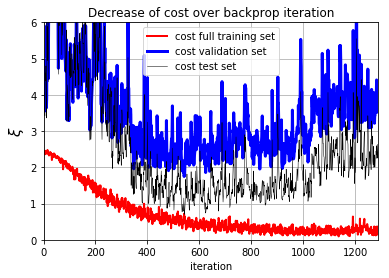

In [69]:
# Plot the minbatch, full training set, and validation costs
minibatch_x_inds = np.linspace(0, nb_of_batches*nb_of_epoch, num = nb_of_batches*nb_of_epoch)
iteration_x_inds = np.linspace(0, nb_of_batches*nb_of_epoch, num = nb_of_batches*nb_of_epoch) 
# Plot the cost over the iterations
plt.plot(minibatch_x_inds, minibatch_cost, 'r-', linewidth=2, label='cost minibatches')
plt.plot(minibatch_x_inds, train_cost, 'k-', linewidth=0.5, label='cost training set')
plt.plot(iteration_x_inds, validation_cost, 'b-', linewidth=3, label='cost validation set')
# Add labels to the plot
plt.xlabel('iteration')
plt.ylabel('$\\xi$', fontsize=15)
plt.title('Decrease of cost over backprop iteration')
plt.legend()
x1,x2,y1,y2 = plt.axis()
plt.axis((0,nb_of_batches*nb_of_epoch,0,6.0))
plt.grid()
plt.show()

In [ ]:
# Get results of test data
y_true = np.argmax(T_validation, axis=1)  
activations = forward_step2(X_validation, layers)  
y_pred = np.argmax(activations[-1], axis=1)  
test_accuracy = metrics.accuracy_score(y_true, y_pred)  
print('The accuracy on the validation set is {:.2f}'.format(test_accuracy))

In [ ]:
# Get results of validation data
y_true = np.argmax(T_test, axis=1)  
activations = forward_step2(X_test, layers)  
y_pred = np.argmax(activations[-1], axis=1)  
test_accuracy = metrics.accuracy_score(y_true, y_pred)  
print('The accuracy on the test set is {:.2f}'.format(test_accuracy))